In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import base64
import requests
import shutil

import networkx as nx

from PIL import Image
from PIL.JpegImagePlugin import JpegImageFile

def draw_tree(tree: nx.Graph) -> JpegImageFile:

    graph_txt = "graph LR;"+";".join([
        f"{str(edge[0]).replace('<','').replace('>','')}"
        f"-"
        f"- {tree.edges[edge]['weight']} -"
        f"->{str(edge[1]).replace('<','').replace('>','')}"
        for edge in tree.edges
    ])
    
    graphbytes = graph_txt.encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    url = "https://mermaid.ink/img/" + base64_string

    response = requests.get(url, stream=True)

    with open('tmp.png', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    return Image.open('tmp.png')

In [60]:
def evaluate(node):
    return -(node - 3)**2 if node>0 else -100

def explore_decision_tree(
    nb_actions: int,
    max_successive_actions: int,
    explore_all_branches: bool = False,
) -> tuple[nx.DiGraph, int, float]:

    def explore_node_recursive(nodes_to_explore, max_reward, node):
        global best_reward, best_node
        best_reward = max_reward
        if node in nodes_to_explore:
            all_evaluated = len(list(tree.successors(node))) == nb_actions
            max_successive_actions_reached = (
                len(nx.shortest_path(tree, source=0, target=node)) 
                > max_successive_actions
            )

            # done = False
            done = node in [6, 7, 9]
            # done = node %7 == 0 and node>0
            # done = node > 1

            reward = tree.nodes[node]['reward']
            if done and reward > max_reward:
                max_reward = reward
                best_node = node
            not_better = reward < max_reward and node > 0
            if explore_all_branches:
                not_better = False
            
            if (all_evaluated or max_successive_actions_reached or done or not_better):
                nodes_to_explore.remove(node)
                next_node = nx.ancestors(tree, node).intersection(nodes_to_explore)
                if next_node:
                    explore_node_recursive(nodes_to_explore, max_reward, max(next_node))
            else:
                new_node_index = tree.number_of_nodes()
                tree.add_node(new_node_index, reward=evaluate(new_node_index))
                tree.add_edge(
                    node,
                    new_node_index,
                    weight=len(list(tree.successors(node)))
                )
                nodes_to_explore.add(new_node_index)
                explore_node_recursive(nodes_to_explore, max_reward, new_node_index)

    
    tree = nx.DiGraph()
    tree.add_node(0, reward=evaluate(0))

    nodes_to_explore = set()
    nodes_to_explore.add(0)

    reward_max = evaluate(0)
    # best_node = None

    explore_node_recursive(nodes_to_explore, reward_max, 0)
    
    return tree, best_node, best_reward

6 -9


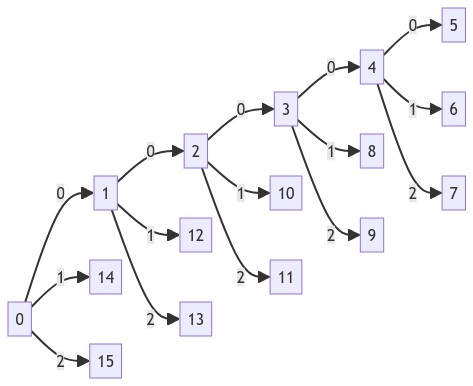

In [61]:
tree, best_node, best_reward = explore_decision_tree(
    nb_actions=3,
    max_successive_actions=5,
    explore_all_branches=False
)
print(best_node, best_reward)
draw_tree(tree)